# Grocery prediction using clique percolation method

## 1. Import modules
* `pandas` and `numpy` for data manipulation
* `turicreate` for performing model selection and evaluation
* `sklearn` for splitting the data into train and test set

In [1]:
!pip install turicreate
!pip install sklearn
!pip install scripts

    100% |████████████████████████████████| 87.4MB 385kB/s 
    100% |████████████████████████████████| 23.8MB 1.2MB/s 
    100% |████████████████████████████████| 2.7MB 12.7MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import time
import turicreate as tc
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
uploaded = files.upload()

Saving recommend_1.csv to recommend_1.csv
Saving trx_data.csv to trx_data.csv


## 2. Load data
Two datasets are used in this exercise, which can be found in `data` folder: 
* `recommend_1.csv` consisting of a list of 1000 customer IDs to recommend as output
* `trx_data.csv` consisting of user transactions

The format is as follows.

In [0]:
import io

customers = pd.read_csv(io.BytesIO(uploaded['recommend_1.csv'])) 
transactions = pd.read_csv(io.BytesIO(uploaded['trx_data.csv']))

In [5]:
print(customers.shape)
customers.head()

(1000, 1)


,customerId
0,1553
1,20400
2,19750
3,6334
4,27773


In [6]:
print(transactions.shape)
transactions.head()

(62483, 2)


,customerId,products
0,0,20
1,1,2|2|23|68|68|111|29|86|107|152
2,2,111|107|29|11|11|11|33|23
3,3,164|227
4,5,2|2


## 3. Data preparation
* Our goal here is to break down each list of items in the `products` column into rows and count the number of products bought by a user

In [7]:
# example 1: split product items
transactions['products'] = transactions['products'].apply(lambda x: [int(i) for i in x.split('|')])
transactions.head(2).set_index('customerId')['products'].apply(pd.Series).reset_index()

,customerId,0,1,2,3,4,5,6,7,8,9
0,0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,2.0,23.0,68.0,68.0,111.0,29.0,86.0,107.0,152.0


In [8]:
transactions.head()

,customerId,products
0,0,[20]
1,1,"[2, 2, 23, 68, 68, 111, 29, 86, 107, 152]"
2,2,"[111, 107, 29, 11, 11, 11, 33, 23]"
3,3,"[164, 227]"
4,5,"[2, 2]"


In [9]:
# example 2: organize a given table into a dataframe with customerId, single productId, and purchase count
pd.melt(transactions.head(2).set_index('customerId')['products'].apply(pd.Series).reset_index(), 
             id_vars=['customerId'],
             value_name='products') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customerId', 'products']) \
    .agg({'products': 'count'}) \
    .rename(columns={'products': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'products': 'productId'})

,customerId,productId,purchase_count
0,0,20.0,1
1,1,2.0,2
2,1,23.0,1
3,1,29.0,1
4,1,68.0,2
5,1,86.0,1
6,1,107.0,1
7,1,111.0,1
8,1,152.0,1


### 3.1. Create data with user, item, and target field
* This table will be an input for our modeling later
    * In this case, our user is `customerId`, `productId`, and `purchase_count`

In [10]:
s=time.time()

data = pd.melt(transactions.set_index('customerId')['products'].apply(pd.Series).reset_index(), 
             id_vars=['customerId'],
             value_name='products') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customerId', 'products']) \
    .agg({'products': 'count'}) \
    .rename(columns={'products': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'products': 'productId'})
data['productId'] = data['productId'].astype(np.int64)

print("Execution time:", round((time.time()-s)/60,2), "minutes")

Execution time: 0.25 minutes


In [11]:
print(data.shape)
data.head()

(133585, 3)


,customerId,productId,purchase_count
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2


In [12]:
max(data['productId']), min(data['productId'])

(299, 0)

###3.2 Creating a NetworkX graph

In [13]:
import networkx as nx

G=nx.Graph()

print(G.nodes())
print(G.edges())

print(type(G.nodes()))
print(type(G.edges()))

[]
[]
<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>


In [14]:
# a list of nodes:
G.add_nodes_from(data['productId'])
print("Nodes of graph: ")
print(G.nodes())

Nodes of graph: 
[1, 13, 19, 20, 31, 52, 69, 93, 136, 157, 198, 216, 255, 256, 260, 2, 23, 25, 29, 61, 68, 86, 107, 111, 122, 135, 146, 151, 152, 227, 241, 274, 285, 293, 296, 11, 33, 55, 100, 121, 164, 196, 15, 143, 199, 200, 270, 289, 18, 36, 59, 60, 91, 130, 149, 264, 94, 144, 266, 51, 159, 206, 259, 280, 8, 9, 14, 21, 35, 47, 48, 71, 73, 79, 95, 113, 133, 160, 163, 165, 167, 168, 177, 180, 187, 195, 202, 212, 225, 229, 247, 248, 251, 0, 17, 30, 72, 87, 102, 148, 297, 16, 24, 49, 66, 77, 78, 84, 101, 104, 153, 166, 175, 190, 201, 290, 10, 34, 42, 45, 50, 76, 82, 117, 127, 171, 173, 181, 213, 219, 234, 287, 291, 172, 183, 192, 240, 38, 58, 105, 7, 43, 56, 65, 118, 120, 131, 271, 96, 140, 244, 279, 70, 4, 224, 39, 281, 12, 26, 28, 139, 194, 242, 261, 282, 3, 44, 85, 103, 179, 185, 189, 232, 269, 208, 97, 124, 203, 218, 236, 154, 161, 276, 209, 83, 106, 5, 158, 67, 114, 116, 41, 141, 197, 249, 267, 53, 81, 99, 108, 115, 205, 272, 62, 231, 292, 63, 145, 40, 46, 119, 176, 237, 273, 277, 

In [0]:
sdata = data.sort_values('customerId')
sdata.head(),sdata.tail()
for i in range(len(data)):
  for j in range(i,len(data)):
    if data['customerId'][i] == data['customerId'][j]:
      edge = (data['productId'][i],data['productId'][j])
      G.add_edge(*edge)
    else:
      break

* Nodes of graph for clique percolation method

In [16]:
print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
[1, 13, 19, 20, 31, 52, 69, 93, 136, 157, 198, 216, 255, 256, 260, 2, 23, 25, 29, 61, 68, 86, 107, 111, 122, 135, 146, 151, 152, 227, 241, 274, 285, 293, 296, 11, 33, 55, 100, 121, 164, 196, 15, 143, 199, 200, 270, 289, 18, 36, 59, 60, 91, 130, 149, 264, 94, 144, 266, 51, 159, 206, 259, 280, 8, 9, 14, 21, 35, 47, 48, 71, 73, 79, 95, 113, 133, 160, 163, 165, 167, 168, 177, 180, 187, 195, 202, 212, 225, 229, 247, 248, 251, 0, 17, 30, 72, 87, 102, 148, 297, 16, 24, 49, 66, 77, 78, 84, 101, 104, 153, 166, 175, 190, 201, 290, 10, 34, 42, 45, 50, 76, 82, 117, 127, 171, 173, 181, 213, 219, 234, 287, 291, 172, 183, 192, 240, 38, 58, 105, 7, 43, 56, 65, 118, 120, 131, 271, 96, 140, 244, 279, 70, 4, 224, 39, 281, 12, 26, 28, 139, 194, 242, 261, 282, 3, 44, 85, 103, 179, 185, 189, 232, 269, 208, 97, 124, 203, 218, 236, 154, 161, 276, 209, 83, 106, 5, 158, 67, 114, 116, 41, 141, 197, 249, 267, 53, 81, 99, 108, 115, 205, 272, 62, 231, 292, 63, 145, 40, 46, 119, 176, 237, 273, 277, 

* Notice how dense the graph is

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


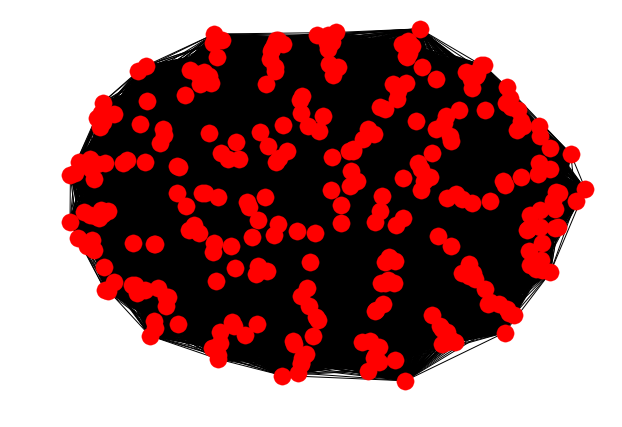

In [17]:
nx.draw(G)

## 4. Clique Percolation Method
* Applying Clique Percolation method on NetworkX graph

* Generating max cliques

In [18]:
from networkx.algorithms.approximation import clique 

c1 = clique.max_clique(G) 
print(c1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 121, 122, 123, 124, 126, 127, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 156, 157, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 186, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 208, 209, 210, 211, 212, 215, 216, 217, 218, 219, 224, 225, 227, 229, 231, 232, 233, 234, 237, 239, 240, 241, 242, 244, 246, 247, 249, 251, 255, 256, 257, 258, 259, 260, 261, 264, 265, 266, 267, 268, 269, 270, 273, 274,

* Clique percolation method would not work since Graph has too many nodes

# Association Rules Mining/Market Basket Analysis
* Source: https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis

## 1 Setting up environment

In [1]:
import os
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jacobjohn2016","key":"0206904f95d5d7e082b1af55b711e3f4"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 Apr  4 11:16 kaggle.json


In [4]:
!ls
!pwd
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json  recommend_1.csv  sample_data  trx_data.csv
/content


In [5]:
!kaggle competitions download -c instacart-market-basket-analysis

  0% 0.00/804 [00:00<?, ?B/s]
100% 804/804 [00:00<00:00, 660kB/s]
  0% 0.00/1.87k [00:00<?, ?B/s]
100% 1.87k/1.87k [00:00<00:00, 1.93MB/s]
 72% 5.00M/6.90M [00:00<00:00, 10.0MB/s]
100% 6.90M/6.90M [00:00<00:00, 12.8MB/s]
  0% 0.00/795k [00:00<?, ?B/s]
100% 795k/795k [00:00<00:00, 52.5MB/s]
 80% 25.0M/31.3M [00:00<00:00, 18.0MB/s]
100% 31.3M/31.3M [00:00<00:00, 40.0MB/s]
 97% 153M/157M [00:04<00:00, 38.5MB/s]
100% 157M/157M [00:04<00:00, 38.1MB/s]
  0% 0.00/220k [00:00<?, ?B/s]
100% 220k/220k [00:00<00:00, 67.4MB/s]


In [6]:
!ls
!unzip order_products__prior.csv
!unzip orders.csv
!unzip products.csv
!unzip aisles.csv
!unzip departments.csv

aisles.csv.zip		       products.csv.zip
departments.csv.zip	       recommend_1.csv
kaggle.json		       sample_data
order_products__prior.csv.zip  sample_submission.csv.zip
order_products__train.csv.zip  trx_data.csv
orders.csv.zip
Archive:  order_products__prior.csv.zip
  inflating: order_products__prior.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._order_products__prior.csv  
Archive:  orders.csv.zip
  inflating: orders.csv              
  inflating: __MACOSX/._orders.csv   
Archive:  products.csv.zip
  inflating: products.csv            
  inflating: __MACOSX/._products.csv  
Archive:  aisles.csv.zip
  inflating: aisles.csv              
  inflating: __MACOSX/._aisles.csv   
Archive:  departments.csv.zip
  inflating: departments.csv         
  inflating: __MACOSX/._departments.csv  


## 2. Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

orders = pd.read_csv('order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### 2.1 Convert order data into format expected by the association rules function

In [8]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

### 2.2  Display summary statistics for order data

In [9]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,);   size: 518.95 MB;   unique_orders: 3214874;   unique_items: 49677


## 3 Association Rules Function

### 3.1 Helper functions to the main association rules function

In [0]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]     

### 3.2 Association rules function

In [0]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

### 3.3 Association Rule Mining

In [12]:
%%time
rules = association_rules(orders, 0.01)  

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751

CPU times: user 9min 5s, sys: 10.4 s, total: 9min 15s
Wall time: 9min 15s


In [13]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


## 4. Conclusion

From the output above, we see that the top associations are not surprising, with one flavor of an item being purchased with another flavor from the same item family (eg: Strawberry Chia Cottage Cheese with Blueberry Acai Cottage Cheese, Chicken Cat Food with Turkey Cat Food, etc). As mentioned, one common application of association rules mining is in the domain of recommender systems. Once item pairs have been identified as having positive relationship, recommendations can be made to customers in order to increase sales. And hopefully, along the way, also introduce customers to items they never would have tried before or even imagined existed!

# Developing Word-Based Neural Language Models in Python with Keras

In [14]:
item_name.head()

,item_id,item_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
orders.head()

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
Name: item_id, dtype: int64

In [16]:
item_name.head()
item_name.loc[100]

item_id                                 101
item_name        Bread, Healthy Whole Grain
aisle_id                                112
department_id                             3
Name: 100, dtype: object

In [17]:
rules_final.head() 

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
